In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import json
import torchvision
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import Subset, random_split
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import pandas as pd
import shutil
from pycocotools import mask as coco_mask
import os
from glob import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
import seaborn as sns
import numpy as np
# from mpl_toolkits.axes_grid import ImageGrid

from tqdm.notebook import tqdm
import time
import random
from PIL import Image


from sklearn.model_selection import train_test_split
from torchvision import transforms
import torchvision.transforms.functional as TF


In [1]:
!git clone https://github.com/jasonfghx/retina_image.git

Cloning into 'retina_image'...
remote: Enumerating objects: 1696, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 1696 (delta 18), reused 0 (delta 0), pack-reused 1635 (from 2)
Receiving objects: 100% (1696/1696), 332.51 MiB | 16.92 MiB/s, done.
Resolving deltas: 100% (136/136), done.
Updating files: 100% (1407/1407), done.


In [3]:
import pandas as pd
image=sorted(glob("/content/retina_image/s1/images/*"))
mask=sorted(glob("/content/retina_image/s1/masks/*"))

In [4]:
dff = pd.DataFrame({"image_path": image,
                   "mask_path": mask})

In [5]:
class Dataset:
    def __init__(self, df,transforms):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0])
        mask = cv2.imread(self.df.iloc[idx, 1], cv2.IMREAD_GRAYSCALE)
        image = Image.fromarray(image)
        mask  = Image.fromarray(mask)
        image, mask = self.transforms(image, mask)



        return image, mask
class ComposeDouble:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, mask):
        for t in self.transforms:
            image, mask = t(image, mask)
        return image, mask
class Resize:
    def __init__(self, size):
        self.size = size  # tuple (H, W)

    def __call__(self, image, mask):
        image = image.resize(self.size, resample=Image.BILINEAR)  # RGB image 用 BILINEAR
        mask  = mask.resize(self.size, resample=Image.NEAREST)    # mask 用 NEAREST 避免插值改變類別
        return image, mask



class ToTensor:
    def __call__(self, image, mask):
        # image: PIL Image -> Tensor (C,H,W)
        image = TF.to_tensor(image).float()  # (3,H,W)

        # mask: PIL Image -> Tensor (1,H,W)
        mask = torch.as_tensor(np.array(mask)/255, dtype=torch.float).unsqueeze(0)  # (1,H,W)

        return image, mask


train_transform = ComposeDouble([
    Resize((64, 64)),
    ToTensor()
])
# 上面64可以改成128,256
train_df, val_df = train_test_split(dff,  test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df,  test_size=0.12)
train_df = train_df.reset_index(drop=True)

print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")
train_dataset = Dataset(train_df,train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=True)

val_dataset = Dataset(val_df,train_transform)
val_dataloader = DataLoader(val_dataset, batch_size=2, num_workers=2, shuffle=True)

test_dataset = Dataset(test_df,train_transform)
test_dataloader = DataLoader(test_dataset, batch_size=26, num_workers=2, shuffle=True)

Train: (73, 2) 
Val: (10, 2) 
Test: (10, 2)


In [ ]:
images, masks = next(iter(train_dataloader))
(masks.numpy())

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),

            nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)
class UpConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.up = nn.Sequential(
                                nn.Upsample(scale_factor=2),
                                nn.Conv2d(ch_in, ch_out,
                                         kernel_size=3,stride=1,
                                         padding=1, bias=True),
                                nn.BatchNorm2d(ch_out),
                                nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = x = self.up(x)
        return x
class AttentionBlock(nn.Module):
    def __init__(self, f_g, f_l, f_int):
        super().__init__()

        self.w_g = nn.Sequential(
                                nn.Conv2d(f_g, f_int,
                                         kernel_size=1, stride=1,
                                         padding=0, bias=True),
                                nn.BatchNorm2d(f_int)
        )

        self.w_x = nn.Sequential(
                                nn.Conv2d(f_l, f_int,
                                         kernel_size=1, stride=1,
                                         padding=0, bias=True),
                                nn.BatchNorm2d(f_int)
        )

        self.psi = nn.Sequential(
                                nn.Conv2d(f_int, 1,
                                         kernel_size=1, stride=1,
                                         padding=0,  bias=True),
                                nn.BatchNorm2d(1),
                                nn.Sigmoid(),
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.w_g(g)
        x1 = self.w_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return psi*x
class AttentionUNet(nn.Module):
    def __init__(self, n_classes=1, in_channel=3, out_channel=1):
        super().__init__()

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = ConvBlock(ch_in=in_channel, ch_out=64)
        self.conv2 = ConvBlock(ch_in=64, ch_out=128)
        self.conv3 = ConvBlock(ch_in=128, ch_out=256)
        self.conv4 = ConvBlock(ch_in=256, ch_out=512)
        # self.conv5 = ConvBlock(ch_in=512, ch_out=1024)

        # self.up5 = UpConvBlock(ch_in=1024, ch_out=512)
        # self.att5 = AttentionBlock(f_g=512, f_l=512, f_int=256)
        # self.upconv5 = ConvBlock(ch_in=1024, ch_out=512)

        self.up4 = UpConvBlock(ch_in=512, ch_out=256)
        self.att4 = AttentionBlock(f_g=256, f_l=256, f_int=128)
        self.upconv4 = ConvBlock(ch_in=512, ch_out=256)

        self.up3 = UpConvBlock(ch_in=256, ch_out=128)
        self.att3 = AttentionBlock(f_g=128, f_l=128, f_int=64)
        self.upconv3 = ConvBlock(ch_in=256, ch_out=128)

        self.up2 = UpConvBlock(ch_in=128, ch_out=64)
        self.att2 = AttentionBlock(f_g=64, f_l=64, f_int=32)
        self.upconv2 = ConvBlock(ch_in=128, ch_out=64)

        self.conv_1x1 = nn.Conv2d(64, out_channel,
                                  kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)

        x2 = self.maxpool(x1)
        x2 = self.conv2(x2)

        x3 = self.maxpool(x2)
        x3 = self.conv3(x3)

        x4 = self.maxpool(x3)
        x4 = self.conv4(x4)

        # x5 = self.maxpool(x4)
        # x5 = self.conv5(x5)

        # decoder + concat
        # d5 = self.up5(x5)
        # x4 = self.att5(g=d5, x=x4)
        # d5 = torch.concat((x4, d5), dim=1)
        # d5 = self.upconv5(d5)
        d4 = self.up4(x4)
        x3 = self.att4(g=d4, x=x3)
        d4 = torch.concat((x3, d4), dim=1)
        d4 = self.upconv4(d4)

        # d4 = self.up4(d5)
        # x3 = self.att4(g=d4, x=x3)
        # d4 = torch.concat((x3, d4), dim=1)
        # d4 = self.upconv4(d4)

        d3 = self.up3(d4)
        x2 = self.att3(g=d3, x=x2)
        d3 = torch.concat((x2, d3), dim=1)
        d3 = self.upconv3(d3)

        d2 = self.up2(d3)
        x1 = self.att2(g=d2, x=x1)
        d2 = torch.concat((x1, d2), dim=1)
        d2 = self.upconv2(d2)

        d1 = self.conv_1x1(d2)

        return d1



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
attention_unet = AttentionUNet(n_classes=1).to(device)


In [7]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target*inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0
    return intersection/union
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

In [11]:
def train_model(model, train_loader, val_loader, train_loss, optimizer, lr_scheduler, num_epochs):


    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        model.train()

        losses = []
        train_iou = []

        for i_step, (data, target) in enumerate(tqdm(train_loader)):
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0

            train_dice = dice_coef_metric(out_cut, target.data.cpu().numpy())

            loss = train_loss(outputs, target)

            losses.append(loss.item())
            train_iou.append(train_dice)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_mean_iou = compute_iou(model, val_loader)

        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)

        print("Epoch [%d]" % (epoch))
        print("Mean loss on train:", np.array(losses).mean(),
              "\nMean DICE on train:", np.array(train_iou).mean(),
              "\nMean DICE on validation:", val_mean_iou)

    return loss_history, train_history, val_history

In [12]:
def compute_iou(model, loader, threshold=0.3):
    valloss = 0

    with torch.no_grad():

        for i_step, (data, target) in enumerate(loader):

            data = data.to(device)
            target = target.to(device)

            outputs = model(data)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0
            picloss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += picloss

    return valloss / i_step
opt = torch.optim.Adamax(attention_unet.parameters(), lr=1e-3)

In [ ]:
num_ep = 40
aun_lh, aun_th, aun_vh = train_model( attention_unet, train_dataloader, val_dataloader, DiceLoss(), opt, False, num_ep)

In [14]:
# 存檔
torch.save(attention_unet, "attention_unet_full.pt")

In [31]:
class ResizeImageOnly:
    def __init__(self, size):
        self.size = size  # (H, W)

    def __call__(self, image):
        return image.resize(self.size, resample=Image.BILINEAR)
class ToTensorImageOnly:
    def __call__(self, image):
        image = TF.to_tensor(image).float()  # (3,H,W) and normalized to 0~1
        return image
class ComposeSingle:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image):
        for t in self.transforms:
            image = t(image)
        return image
inference_transform = ComposeSingle([
    ResizeImageOnly((64, 64)),
    ToTensorImageOnly()
])
img = Image.open('/content/retina_image/s1/images/Stage_1_ROP_2.jpg').convert("RGB")   # 讀檔
tensor = inference_transform(img)                 # Resize + ToTensor
tensor = tensor.unsqueeze(0)

In [32]:
attention_unet.eval()              # 切成推論模式

with torch.no_grad():     # 關掉梯度，避免浪費記憶體與速度
    img_tensor = tensor.to(device)

    output = attention_unet(img_tensor)      # [B,1,H,W] 或 [B,2,H,W]
    prob = torch.sigmoid(output)    # 如果你的最後一層沒有 sigmoid
    pred = (prob > 0.5).float()


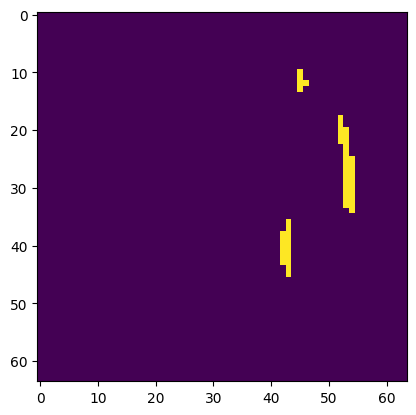

In [33]:
plt.imshow(pred.cpu().numpy()[0][0])